In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Ignore exceptions
import expectexception

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

# Load ipywidgets module
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
%%R

# load the r library
library(ggplot2)
library(ggalt)
theme_set(theme_light())

library(scales)
library(dplyr)

/Users/nelson/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:


Attaching package: ‘dplyr’



/Users/nelson/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:

The following objects are masked from ‘package:stats’:

    filter, lag



/Users/nelson/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





In [3]:
hedge = pd.read_csv('hedge_ratio.csv')

hedge['ticker'] = hedge['ticker'].astype('category')

hedge['product'] = hedge['product'].astype('category')

In [4]:
hedge_mean = hedge.groupby(['ticker', 'product']).mean().reset_index().drop('year', axis=1)

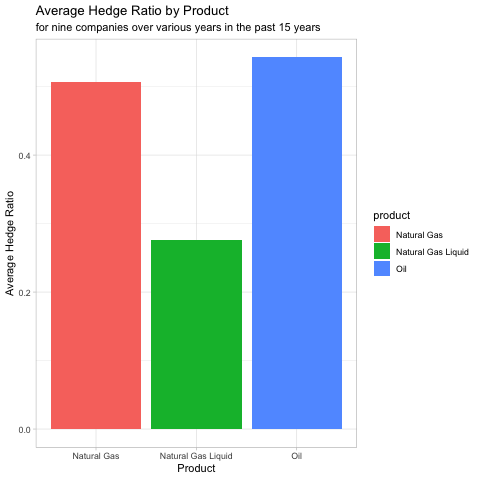

In [5]:
%%R -i hedge_mean

hedge_product_average = hedge_mean %>%
    group_by(product) %>%
    summarize(avg_hedge = mean(hedge_ratio, na.rm = T))

ggplot(hedge_product_average, aes(product, avg_hedge)) +
    geom_bar(stat='identity', aes(fill=product)) +
    labs(title='Average Hedge Ratio by Product',
         subtitle='for nine companies over various years in the past 15 years',
         x='Product',
         y='Average Hedge Ratio')

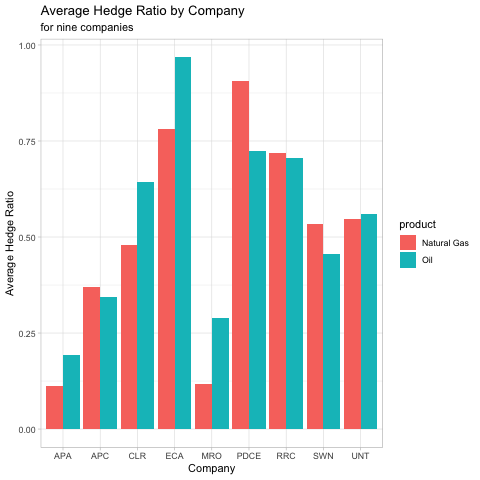

In [6]:
%%R -i hedge_mean -o hedge_mean_rmNGL

hedge_mean_rmNGL = hedge_mean %>%
filter(product != 'Natural Gas Liquid')

ggplot(hedge_mean_rmNGL, aes(x=ticker, y=hedge_ratio)) +
    geom_bar(stat='identity', aes(y=hedge_ratio, fill=product), position='dodge') +
    labs(title='Average Hedge Ratio by Company',
         subtitle='for nine companies',
         x='Company',
         y='Average Hedge Ratio')

In [7]:
%%R -i hedge_mean_rmNGL

t.test(hedge_ratio~product, paired=T, data=hedge_mean_rmNGL)


	Paired t-test

data:  hedge_ratio by product
t = -0.84465, df = 8, p-value = 0.4228
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.13234254  0.06138411
sample estimates:
mean of the differences 
            -0.03547921 



In [8]:
# True difference in mean natural gas hedge ratio and mean oil hedge ratio is not equal (p = 0.4228)

In [9]:
hedge_NG = hedge_mean_rmNGL.loc[hedge_mean_rmNGL['product'] == 'Natural Gas']
hedge_OIL = hedge_mean_rmNGL.loc[hedge_mean_rmNGL['product'] == 'Oil']

In [10]:
hedge_NG

,ticker,product,volume,production,hedge_ratio
0,APA,Natural Gas,77843.422,674996.122,0.111
2,APC,Natural Gas,280416.907,734697.269,0.370
4,CLR,Natural Gas,65944.895,114207.405,0.478
6,ECA,Natural Gas,314630.000,402960.000,0.781
8,MRO,Natural Gas,37849.920,327575.333,0.118
10,PDCE,Natural Gas,26470.155,38289.995,0.907
12,RRC,Natural Gas,147618.539,207267.387,0.719
14,SWN,Natural Gas,165443.571,385633.306,0.534
16,UNT,Natural Gas,27541.294,50604.539,0.546


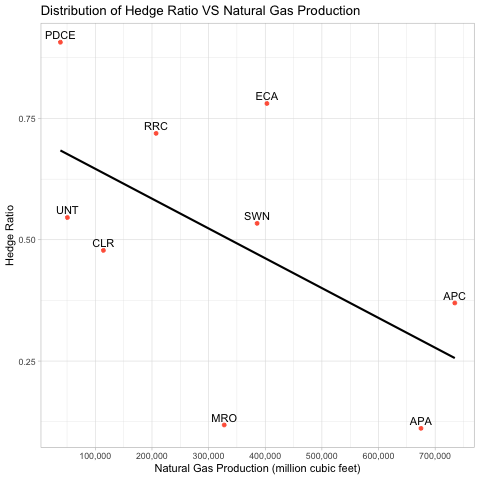

In [11]:
%%R -i hedge_NG

ggplot(hedge_NG, aes(x=production, y=hedge_ratio, label=ticker)) +
    geom_point(col='tomato') +
    geom_smooth(method='lm', aes(group=1), se=F, col='black') +
    scale_x_continuous(breaks=seq(0, 850000, by=100000), labels=comma) +
    labs(title='Distribution of Hedge Ratio VS Natural Gas Production',
         x='Natural Gas Production (million cubic feet)',
         y='Hedge Ratio') +
    geom_text(aes(label=ticker), vjust=-0.5)

In [12]:
%%R -i hedge_NG

lm = lm(hedge_ratio~production, data=hedge_NG)
summary(lm)


Call:
lm(formula = hedge_ratio ~ production, data = hedge_NG)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38803 -0.15931  0.06316  0.13902  0.32080 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  7.076e-01  1.371e-01   5.159  0.00131 **
production  -6.145e-07  3.389e-07  -1.813  0.11272   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2434 on 7 degrees of freedom
Multiple R-squared:  0.3195,	Adjusted R-squared:  0.2223 
F-statistic: 3.287 on 1 and 7 DF,  p-value: 0.1127



In [13]:
# There is no statistically significant linear relationship 
# between hedge ratio and natural gas production (p = 0.1127)

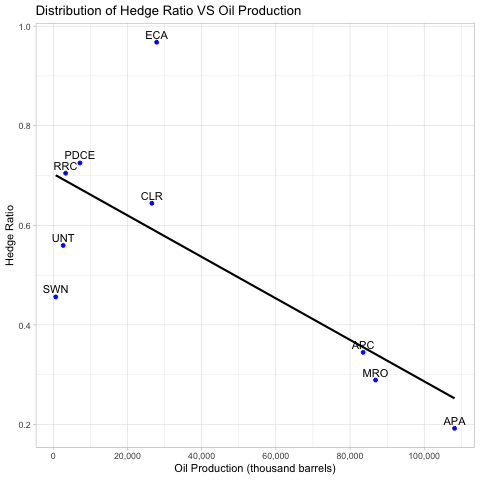

In [14]:
%%R -i hedge_OIL

ggplot(hedge_OIL, aes(x=production, y=hedge_ratio, label=ticker)) +
    geom_point(col='blue') +
    geom_smooth(method='lm', aes(group=1), se=F, col='black') +
    scale_x_continuous(breaks=seq(0, 100000, by=20000), labels=comma) +
    labs(title='Distribution of Hedge Ratio VS Oil Production',
         x='Oil Production (thousand barrels)',
         y='Hedge Ratio') +
    geom_text(aes(label=ticker), vjust=-0.5)

In [15]:
%%R -i hedge_OIL

lm = lm(hedge_ratio~production, data=hedge_OIL)
summary(lm)
# confint(lm, 'production')


Call:
lm(formula = hedge_ratio ~ production, data = hedge_OIL)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24441 -0.06017 -0.01033  0.05178  0.38055 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.032e-01  8.463e-02   8.309 7.15e-05 ***
production  -4.167e-06  1.523e-06  -2.736   0.0291 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1829 on 7 degrees of freedom
Multiple R-squared:  0.5167,	Adjusted R-squared:  0.4477 
F-statistic: 7.485 on 1 and 7 DF,  p-value: 0.02909



In [16]:
# Hedge ratio on oil decreases by 0.0833 (95%CI: [0.0113, 0.155])
# for every 20M barrels increment in oil production (p=0.0291)

In [17]:
hedge_oil = hedge.loc[(hedge['product'] == 'Oil') & (hedge['ticker'] != 'ECA')]
hedge_ng = hedge.loc[(hedge['product'] == 'Natural Gas') & (hedge['ticker'] != 'ECA')]

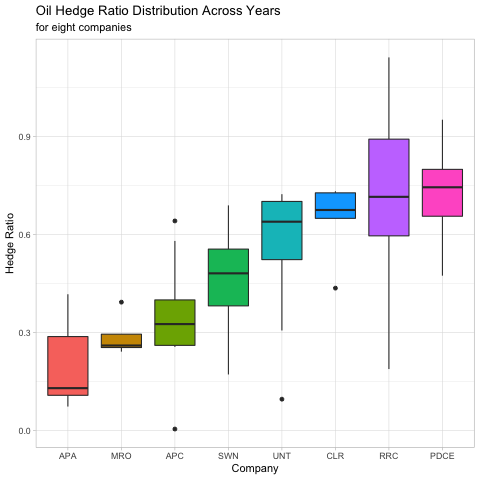

In [18]:
%%R -i hedge_oil

order = c('APA', 'MRO', 'APC', 'SWN', 'UNT', 'CLR', 'RRC', 'PDCE')
hedge_oil = hedge_oil %>%
    mutate(ticker = factor(ticker, levels = order))

ggplot(hedge_oil, aes(ticker, hedge_ratio)) +
    geom_boxplot(aes(fill=ticker)) +
    labs(title='Oil Hedge Ratio Distribution Across Years',
         subtitle='for eight companies',
         x='Company',
         y='Hedge Ratio') +
    theme(legend.position='none')

In [19]:
%%R -i hedge_oil

aov = aov(hedge_ratio~ticker, data=hedge_oil)
summary(aov)
# TukeyHSD(aov)

            Df Sum Sq Mean Sq F value   Pr(>F)    
ticker       7  2.214  0.3163   7.824 1.74e-06 ***
Residuals   53  2.143  0.0404                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [20]:
# There are significant difference in hedge ratios between the companies (p<0.0001)
# Doing Tukey's pairwise comparison,
# There is significant difference in mean hedge ratio between APA, and {UNT, CLR, RRC, PDCE}
# There is significant difference in mean hedge ratio between APC, and {RRC, PDCE}
# There is significant difference in mean hedge ratio between MRO, and {RRC, PDCE}

In [21]:
hedge_ng.groupby('ticker').agg({'hedge_ratio':'median'}).sort_values('hedge_ratio')

,hedge_ratio
ticker,
APA,0.122
MRO,0.123
APC,0.345
CLR,0.505
SWN,0.519
UNT,0.616
PDCE,0.652
RRC,0.695
ECA,nan


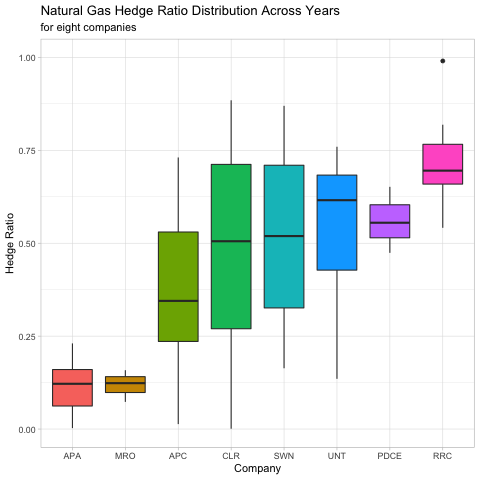

In [22]:
%%R -i hedge_ng

order = c('APA', 'MRO', 'APC', 'CLR', 'SWN', 'UNT', 'PDCE', 'RRC')
hedge_ng = hedge_ng %>%
    mutate(ticker = factor(ticker, levels = order))

ggplot(hedge_ng, aes(ticker, hedge_ratio)) +
    geom_boxplot(aes(fill=ticker)) +
    labs(title='Natural Gas Hedge Ratio Distribution Across Years',
         subtitle='for eight companies',
         x='Company',
         y='Hedge Ratio') +
    theme(legend.position='none') +
    ylim(0,1)

In [23]:
%%R -i hedge_ng

aov = aov(hedge_ratio~ticker, data=hedge_ng)
summary(aov)
# TukeyHSD(aov)

            Df Sum Sq Mean Sq F value   Pr(>F)    
ticker       7  3.508  0.5011   8.849 1.07e-07 ***
Residuals   68  3.851  0.0566                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [24]:
hedge_equ = hedge.copy()

hedge_equ = hedge_equ.loc[hedge_equ['product'] != 'Natural Gas Liquid']

hedge_equ['multiplier'] = np.where(hedge_equ['product'] == 'Natural Gas', 1/6, 1)

hedge_equ['production_equivalence'] = hedge_equ['production'] * hedge_equ['multiplier']

In [25]:
sum_production = hedge_equ.groupby(['ticker', 'year']).agg({'production_equivalence': 'sum'}).reset_index()

hedge_equ_merge = pd.merge(hedge_equ, sum_production, on=['ticker', 'year'])

In [26]:
hedge_equ_merge_oil = hedge_equ_merge.loc[hedge_equ_merge['product'] == 'Oil',
                                          ['ticker', 'production_equivalence_x', 'production_equivalence_y']]

In [27]:
hedge_equ_merge_oil['oil_production_ratio'] = \
hedge_equ_merge_oil['production_equivalence_x'] / hedge_equ_merge_oil['production_equivalence_y']

hedge_equ_merge_oil.drop(['production_equivalence_x', 'production_equivalence_y'], axis=1, inplace=True)

In [28]:
hedge_equ_merge_oil = hedge_equ_merge_oil.loc[hedge_equ_merge_oil['ticker'] != 'ECA']

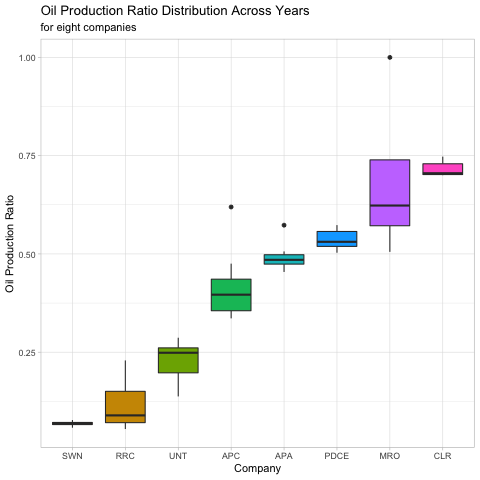

In [29]:
%%R -i hedge_equ_merge_oil

order = c('SWN', 'RRC', 'UNT', 'APC', 'APA', 'PDCE', 'MRO', 'CLR')
hedge_equ_merge_oil = hedge_equ_merge_oil %>%
    mutate(ticker = factor(ticker, levels = order))

ggplot(hedge_equ_merge_oil, aes(ticker, oil_production_ratio)) +
    geom_boxplot(aes(fill=ticker)) +
    labs(title='Oil Production Ratio Distribution Across Years',
         subtitle='for eight companies',
         x='Company',
         y='Oil Production Ratio') +
    theme(legend.position='none')

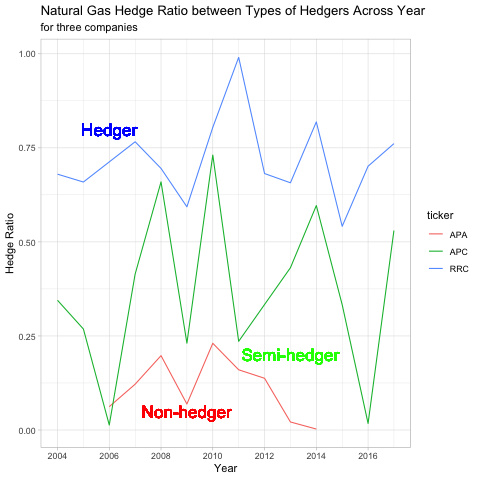

In [30]:
%%R -i hedge_ng

hedge_ng = hedge_ng %>%
    filter(ticker %in% c('APA', 'APC', 'RRC'))

ggplot(hedge_ng, aes(x=year)) +
    geom_line(aes(y=hedge_ratio, col=ticker)) +
    geom_text(x=2009, y=0.05, label='Non-hedger', size=6, color='red') +
    geom_text(x=2013, y=0.2, label='Semi-hedger', size=6, color='green') +
    geom_text(x=2006, y=0.8, label='Hedger', size=6, color='blue') +
    labs(title='Natural Gas Hedge Ratio between Types of Hedgers Across Year',
         subtitle='for three companies',
         x='Year',
         y='Hedge Ratio') +
    scale_x_continuous(breaks=seq(2004, 2018, by=2))

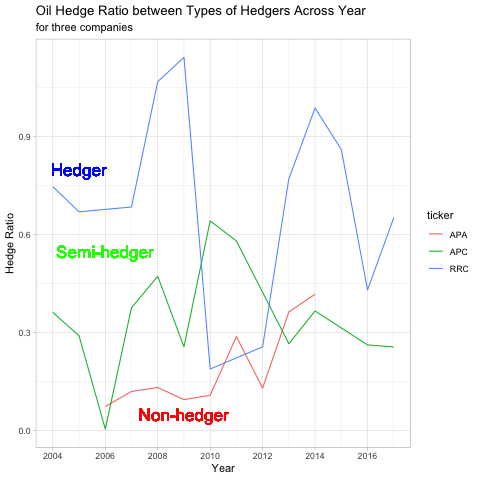

In [31]:
%%R -i hedge_oil

hedge_oil = hedge_oil %>%
    filter(ticker %in% c('APA', 'APC', 'RRC'))

ggplot(hedge_oil, aes(x=year)) +
    geom_line(aes(y=hedge_ratio, col=ticker)) +
    geom_text(x=2009, y=0.05, label='Non-hedger', size=6, color='red') +
    geom_text(x=2006, y=0.55, label='Semi-hedger', size=6, color='green') +
    geom_text(x=2005, y=0.8, label='Hedger', size=6, color='blue') +
    labs(title='Oil Hedge Ratio between Types of Hedgers Across Year',
         subtitle='for three companies',
         x='Year',
         y='Hedge Ratio') +
    scale_x_continuous(breaks=seq(2004, 2018, by=2))